In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
    
import tensorflow as tf

from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model

In [12]:
# Directory for dataset
train_csv_dir = "/kaggle/input/siim-isic-melanoma-classification/train.csv"
train_jpeg_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

In [13]:
# Read datasets
train_features = pd.read_csv(train_csv_dir)

In [14]:
train_features.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

In [15]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


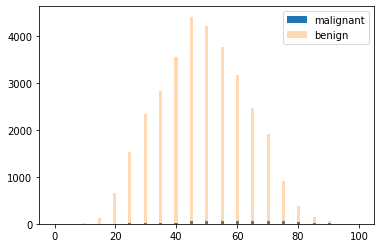

In [16]:
# Let's see the age histogram of malignant and benign cases
# We will also see that the dataset is dramatically imbalanced

bins = np.linspace(0, 100, 100)
plt.hist((train_features['age_approx'][train_features['target']==1]), bins, alpha=1, label='malignant')
plt.hist((train_features['age_approx'][train_features['target']==0]), bins, alpha=0.3, label='benign')
plt.legend(loc='upper right')
plt.show()

In [17]:
# Sex features
train_features['sex'] = train_features['sex'].map({'male': 1, 'female': 0})
train_features['sex'] = train_features['sex'].fillna(-1)

In [18]:
# Converting 'image_name' column for taking images
train_features['image_name'] = train_features['image_name'].apply(lambda x : train_jpeg_dir + x + ".jpg")

In [19]:
# location features
location_train = pd.get_dummies(train_features.anatom_site_general_challenge, prefix='loc')
train_features = pd.concat((train_features[['image_name', 'age_approx', 'sex']], location_train, train_features[['target']]), axis = 1)

In [20]:
train_features.head()

,image_name,age_approx,sex,loc_head/neck,loc_lower extremity,loc_oral/genital,loc_palms/soles,loc_torso,loc_upper extremity,target
0,/kaggle/input/siim-isic-melanoma-classificatio...,45.0,1.0,1,0,0,0,0,0,0
1,/kaggle/input/siim-isic-melanoma-classificatio...,45.0,0.0,0,0,0,0,0,1,0
2,/kaggle/input/siim-isic-melanoma-classificatio...,50.0,0.0,0,1,0,0,0,0,0
3,/kaggle/input/siim-isic-melanoma-classificatio...,45.0,0.0,1,0,0,0,0,0,0
4,/kaggle/input/siim-isic-melanoma-classificatio...,55.0,0.0,0,0,0,0,0,1,0


In [21]:
train_features_malignant = np.copy(train_features[train_features['target']==1])
train_features_benign = np.copy(train_features[train_features['target']==0])

train_id_malignant = np.copy(train_features[train_features['target']==1])
train_id_benign = np.copy(train_features[train_features['target']==0])

train_features_benign_rest, train_features_benign_sample = train_test_split(train_features_benign,  
                                                                            test_size = 0.25, random_state = 7, shuffle = True)


In [22]:
# before age normalization, we split the dataset to avoid data leakage
train_features_benign_sample, val_features_benign_sample= train_test_split(
    train_features_benign_sample, test_size = 0.15, random_state = 7, shuffle = True)
    
val_features_benign_sample, testval_features_benign_sample = train_test_split(
    val_features_benign_sample, test_size = 0.50, random_state = 7, shuffle = True )

train_features_malignant, val_features_malignant= train_test_split(
    train_features_malignant, test_size = 0.15, random_state = 7, shuffle = True)
    
val_features_malignant, testval_features_malignant = train_test_split(
    val_features_malignant, test_size = 0.50, random_state = 7, shuffle = True )

In [23]:
train_features_sample = np.concatenate((train_features_benign_sample, train_features_malignant), axis = 0)
val_features_sample = np.concatenate((val_features_benign_sample, val_features_malignant), axis = 0)
testval_features_sample = np.concatenate((testval_features_benign_sample, testval_features_malignant), axis = 0)

In [ ]:
# Age features after split
def robust_scaler(X):
    scaler = RobustScaler()
    age_scaled = scaler.fit_transform(X[:,1].reshape(-1, 1))
    X[:,1] = age_scaled.reshape(-1,)
    return X

train = robust_scaler(train_features_sample)
val = robust_scaler(val_features_sample)
testval = robust_scaler(testval_features_sample)

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, files, features, labels, batch_size, shuffle, random_state):
        'Initialization'
        self.files = files
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.on_epoch_end()
    
    
    def __len__(self):
        l = int(np.floor(len(self.files) / self.batch_size))
        if l*self.batch_size < len(self.files):
            l += 1
        return l
 

    def __getitem__(self, index):
        # Generate indexes of the batch

        y = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        f = self.features[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        x = self.__data_generation(self.files[index*self.batch_size:(index+1)*self.batch_size])

        return [np.array(x), np.array(f).astype('float32')], np.array(y).astype('int')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    
    def __data_generation(self, files):
             
        imgs = []
        def image_read(img_file):
            image = tf.io.read_file(img_file)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.cast(image, tf.float32)
            image = tf.image.resize(image, (256, 256))
            image = tf.keras.applications.efficientnet.preprocess_input(image) 
            return image

        for img_file in files:
            img = image_read(img_file)
            imgs.append(img) 
        
        return imgs

In [ ]:
# Create base model
noisy_student = "../input/efficientnet-noisy-student-keras-applications/efficientnetb5_notop.h5"
efnet = tf.keras.applications.EfficientNetB5(
    input_shape=(256, 256, 3), include_top=False)
efnet.load_weights(noisy_student, by_name=True)
# Freeze base model
efnet.trainable = False



In [ ]:
def build_model():
    
    input_image = Input(shape=(256, 256, 3))
    input_feature = Input(shape=(8,))
    
    img_augmentation = Sequential([   
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(0.1, 0.2), fill_mode = 'reflect'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode = 'reflect'),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(0.05, 0.15))],
    name="img_augmentation")
    
    x1 = img_augmentation(input_image)

    # We make sure that the base_model is running in inference mode here by passing `training=False`. 
    x1 = efnet(x1, training=False)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)

    # Train the feature map with dense layers
    x2 = tf.keras.layers.Dense(units = 64, activation="relu")(input_feature)

    # concatenate outputs of two models
    x = tf.keras.layers.concatenate([x1, x2])
    
    # Train merged data with a dense layer
    x = tf.keras.layers.Dense(units = 64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # make a prediction with single sigmoid unit
    outputs = tf.keras.layers.Dense(units = 1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=[input_image, input_feature], outputs=outputs)
   
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100, decay_rate=0.9,
        staircase=True)

    # Compiling and Fitting the model
    model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
              metrics=[tf.keras.metrics.AUC()])
    
    return model

In [ ]:
initial_learning_rate = 0.001

model = build_model()
model.summary()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Early stopping helps as it stops training if val_loss(validation score) does not decrease.
early_stopping = EarlyStopping(patience = 5, mode='max', 
                              monitor='val_auc', restore_best_weights=True)

# Class weights since the dataset is imbalanced 
class_weight = {0: 0.07,
               1: 0.93}

# Reduce learning rate when there is no improvement on val_auc
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                              patience=5, min_lr=0.01)

# save the best model               
bestmodel_path = './bestmodel/'
cp_callback = ModelCheckpoint(filepath = bestmodel_path, mode='max', 
                              monitor='val_auc', 
                              verbose=2, save_best_only=True)


In [ ]:
# train the model
batch_size=64
predictor = model.fit(DataGenerator(files = train[:,0], 
                                    features = train[:,1:-1], 
                                    labels = train[:,-1], 
                                    batch_size = batch_size, shuffle=True, random_state=7),
                      
                      validation_data = (DataGenerator(files = val[:,0], 
                                                       features = val[:,1:-1], 
                                                       labels = val[:,-1], 
                                                       batch_size = batch_size, shuffle=False, random_state=7)),
                               
                      epochs=5, verbose = 1 #, class_weight = class_weight, callbacks = [early_stopping, reduce_lr, cp_callback])

In [ ]:
# plot loss during training
plt.title('AUC')
plt.plot(predictor.history['auc'], label='train')
plt.plot(predictor.history['val_auc'], label='validation')
plt.legend()
plt.show()

# plot loss during training
plt.title('LOSS')
plt.plot(predictor.history['loss'], label='train')
plt.plot(predictor.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
test_generetor = DataGenerator(files = testval[:,0], 
                                              features = testval[:,1:-1],
                                              labels = testval[:,-1], 
                                              batch_size = 1, shuffle=False, random_state=7)

In [ ]:
prediction = model.predict_generator(test_generetor, len(testval))
y_pred = [1 if x >= 0.5 else 0 for x in prediction]
print(classification_report(testval[:,-1].astype('int'), np.array(y_pred).astype('int')))

In [ ]:
cm = confusion_matrix(testval[:,-1].astype('int'), np.array(y_pred).astype('int'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['benign', 'malignant'])
disp.plot()

In [ ]:
model.save('./model/')